# Airbnb Rio de Janeiro - AutoML

# 1. Introdução

Esse notebook propõe aplicar o processo de AutoML para encontrar o melhor modelo que se adequa aos [dados do Airbnb na cidade do Rio de Janeiro](https://insideairbnb.com/get-the-data/#:~:text=Rio%20de%20Janeiro%2C%20Rio%20de%20Janeiro%2C%20Brazil). 

Os dados são carregados do processo de [feature engineering](https://github.com/BPRateiro/rio-airbnb-data-analysis/blob/main/notebooks/feature_engineering.ipynb).Incluem informações detalhadas sobre a disponibilidade de listagens, características dos imóveis, interações de usuários, e preços. 

O objetivo principal é construir um modelo com as melhores métricas possíveis.

## 1.1 Configurações e bibliotecas

In [4]:
import pandas as pd
from pycaret.regression import setup, compare_models, tune_model, finalize_model, save_model, load_model, plot_model, interpret_model

import sys
import os
sys.path.append(os.path.abspath('..'))

from rio_airbnb.config import MODELS_DIR

## 1.2 Leitura dos dados

In [5]:
df_train = pd.read_parquet('../data/silver/fe_train_output.parquet')
df_test = pd.read_parquet('../data/silver/fe_test_output.parquet')

df_train.drop(columns=[col for col in df_train.columns if df_train[col].nunique() == 1], inplace=True)

df_train.head()

,accommodates,availability_365,availability_60,bathrooms,bedrooms,beds,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,days_since_first_review,...,review_scores_value,reviews_per_month,verification_email,verification_work_email,was_reviewed,host_response_time_within_a_day,host_response_time_within_a_few_hours,host_response_time_within_an_hour,room_type_others,room_type_private_room
0,5.0,269.0,59.0,2.0,1.0,2.0,1.0,0.0,0.0,131.8,...,4.502,1.700,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,4.0,176.0,56.0,2.0,2.0,0.0,6.0,0.0,0.0,173.0,...,4.500,0.690,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2,2.0,267.0,59.0,1.0,1.0,1.0,0.0,2.0,0.0,151.4,...,4.600,0.448,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
3,2.0,38.0,35.0,1.0,1.0,1.0,1.0,1.0,0.0,531.0,...,5.000,0.230,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
4,5.0,10.0,10.0,2.0,2.0,3.0,1.0,0.0,0.0,3631.0,...,4.740,3.040,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0


# 2. Comparação de modelos

O AutoML testa um conjunto de diferentes modelos com valores de hiperparâmetros padrão. O modelo que apresentou melhores métricas foi o **Light Gradient Boosting Machine**.

In [6]:
reg_setup = setup(
    data=df_train, 
    test_data=df_test,
    target="price",
    index=False,
    preprocess=False, 
    session_id=75, 
    profile=True
)
best_model = compare_models()

,Description,Value
0,Session id,75
1,Target,price
2,Target type,Regression
3,Original data shape,"(30299, 44)"
4,Transformed data shape,"(30299, 44)"
5,Transformed train set shape,"(24255, 44)"
6,Transformed test set shape,"(6044, 44)"
7,Numeric features,43


Loading profile... Please Wait!


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lightgbm,Light Gradient Boosting Machine,104.8565,22328.1710,149.4081,0.5930,0.4009,0.3583,0.9220
xgboost,Extreme Gradient Boosting,105.2890,22421.7600,149.7201,0.5913,0.4238,0.3608,0.9370
et,Extra Trees Regressor,109.3373,23915.1321,154.6148,0.5641,0.4183,0.3880,17.4190
rf,Random Forest Regressor,110.7854,24434.7657,156.2870,0.5547,0.4258,0.3976,30.4800
gbr,Gradient Boosting Regressor,113.0925,25166.2398,158.6144,0.5414,0.4304,0.3951,5.7770
ridge,Ridge Regression,129.1917,31335.1584,176.9584,0.4293,0.5361,0.4744,0.0310
br,Bayesian Ridge,129.1985,31331.7076,176.9488,0.4293,0.5350,0.4745,0.0670
lr,Linear Regression,129.2887,31346.2922,176.9903,0.4291,0.5331,0.4752,0.7280
lar,Least Angle Regression,132.2171,32474.1531,180.1629,0.4083,0.5713,0.4903,0.0340
llar,Lasso Least Angle Regression,132.8168,33033.9531,181.6902,0.3983,0.5216,0.4983,0.0320


# 3. Ajuste de hiperparâmetros

Usando o modelo padrão que apresentou as melhores métricas, escolheremos os melhores hiperparâmetros para o lightgbm. Utilizaremos o método Baysean search para definir o espaço de busca.

In [7]:
tuned_model = tune_model(best_model, search_library="scikit-optimize")

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,102.1262,21649.4917,147.1377,0.6045,0.3925,0.3493
1,99.5593,20157.8603,141.9784,0.6356,0.3866,0.3428
2,99.8725,20939.5598,144.7051,0.6033,0.3819,0.3375
3,100.8794,20941.4715,144.7117,0.6271,0.3792,0.3296
4,102.2066,21355.6823,146.1358,0.6198,0.3839,0.3361
5,100.2025,21042.8337,145.0615,0.6390,0.3835,0.3421
6,100.2273,20742.4243,144.0223,0.6083,0.3927,0.3507
7,98.7720,19753.9951,140.5489,0.6281,0.3809,0.3385
8,104.6027,22380.7409,149.6019,0.5942,0.3949,0.3497


Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits


# 4. Treino completo

Agora que o modelo está otimizado, retreinamos utilizando todos dados disponíveis.

In [8]:
final_model = finalize_model(tuned_model)
model, filepath = save_model(final_model.steps[-1][1], MODELS_DIR / "auto_ml", model_only=True)

Model Successfully Saved


# 5. Interpretação dos resultados

## 5.1 Feature importance

- `longitude` e `latitude` aparecem como as mais importantes no modelo, nessa ordem. Isso sugere que a localização geográfica tem um impacto significativo no modelo.
- `days_since_last_review` também tem alta importância. Propriedades que receberam avaliações mais recentes podem ser vistas como mais ativas ou confiáveis.
- `availability_365` reflete a importância da disponibilidade anual da propriedade no modelo.
- `days_since_host_active` sugere que anfitriões mais ativos tornam as propriedades mais atraentes.
- `reviews_per_month` indica que propriedades com mais avaliações mensais são mais populares.
- `num_amenities` mostra que mais comodidades aumentam a atratividade da propriedade.
- `description_length` sugere que descrições mais detalhadas ajudam a melhorar a taxa de reservas.
- `host_acceptance_rate` indica que anfitriões com alta taxa de aceitação recebem mais reservas.
- `days_since_first_review` tem pouco impacto, mas pode refletir a experiência da propriedade na plataforma.

Transformation Pipeline and Model Successfully Loaded


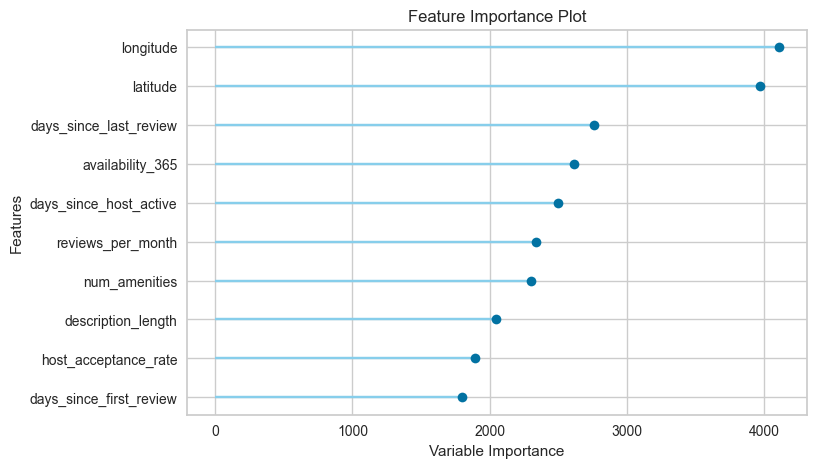

In [9]:
model = load_model(MODELS_DIR / "auto_ml")
plot_model(model, plot='feature')

## 5.2 Beeswarm plot

- `latitude`: Valores mais altos de latitude tendem a diminuir a previsão do modelo, enquanto valores mais baixos aumentam, sugerindo que imóveis localizados em áreas mais ao sul são mais valorizados.
- `longitude`: Valores mais altos de longitude aumentam a previsão, enquanto valores mais baixos a diminuem, sugerindo que imóveis mais a leste são considerados mais valiosos.
- `bedrooms`: Quanto mais quartos, maior o impacto positivo na previsão, indicando que o número de quartos contribui diretamente para o aumento do preço da propriedade.
- `days_since_last_review`: Quanto mais recente a última avaliação, menor o preço previsto. Isso sugere que propriedades com avaliações recentes podem ter preços mais baixos devido à maior rotatividade.
- `bathrooms`: Mais banheiros tendem a aumentar a previsão do preço, o que é esperado, já que um maior número de banheiros geralmente está associado a propriedades mais caras.
- `accommodates`: A capacidade de acomodação tem um impacto positivo na previsão, onde mais capacidade está associada a preços mais altos.
- `host_responded`: Quando o anfitrião responde, isso tende a reduzir o preço, possivelmente indicando que há negociação ou maior flexibilidade de preços.
- `reviews_per_month`: Um maior número de avaliações mensais está associado a uma diminuição no preço, o que pode indicar uma alta demanda por propriedades mais acessíveis.
- `number_of_reviews`: Um maior número total de avaliações parece ter um impacto negativo na previsão, sugerindo que propriedades com muitas avaliações podem ter preços mais baixos, talvez devido a uma maior rotatividade ou acessibilidade.
- `room_type_private_room`: Quartos privados tendem a ter um impacto negativo na previsão em comparação a outros tipos de quartos, indicando que são tipicamente mais baratos. 

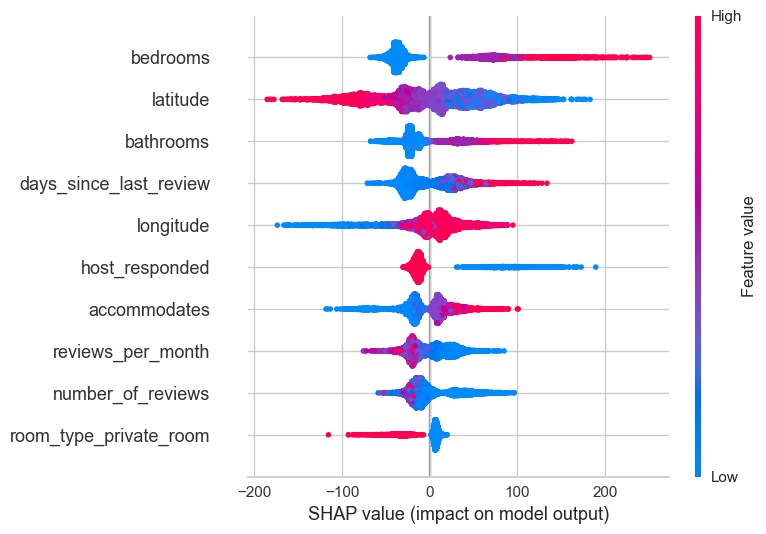

In [10]:
interpret_model(model, max_display=10)

In [11]:
interpret_model(model, plot='pdp', feature='latitude')

[LightGBM] [Warning] feature_fraction is set=0.7709828932730298, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7709828932730298
[LightGBM] [Warning] bagging_fraction is set=0.9568332467165983, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9568332467165983
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.7709828932730298, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7709828932730298
[LightGBM] [Warning] bagging_fraction is set=0.9568332467165983, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9568332467165983
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.7709828932730298, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7709828932730298
[LightGBM] [Warning] bagging

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'fill': 'tonexty',
              'fillcolor': 'rgba(68, 68, 68, 0.15)',
              'line': {'color': '#1f77b4'},
              'mode': 'lines',
              'name': 'Main',
              'type': 'scatter',
              'x': array([-23.07327652, -23.00456153, -22.98471175, -22.98166021, -22.97506205,
                          -22.96850967, -22.96367264, -22.94460678, -22.91932424, -22.75094032]),
              'xaxis': 'x',
              'y': array([467.54090232, 417.92553481, 422.30175471, 395.45266318, 381.76702826,
                          356.40180084, 338.19750092, 316.4426509 , 265.93762562, 241.72058546]),
              'yaxis': 'y'},
             {'connectgaps': True,
              'line': {'width': 1.5},
              'mode': 'lines',
              'name': 'Background: 1',
              'opacity': 0.3,
              'type': 'scatter',
              'x': array([-23.07327652, -23.00456153, -22.98471175, -22.98166021, -22.97506205,
                          -22.96850967, -22.96367264, -22.94460678, -22.91932424, -22.75094032]),
              'xaxis': 'x',
              'y': array([329.60767076, 273.14187592, 259.0324479 , 230.71636029, 230.5649012 ,
                          231.20627512, 215.23491231, 209.70232878, 149.23102149, 131.29920668]),
              'yaxis': 'y'},
             {'connectgaps': True,
              'line': {'width': 1.5},
              'mode': 'lines',
              'name': 'Background: 2',
              'opacity': 0.3,
              'type': 'scatter',
              'x': array([-23.07327652, -23.00456153, -22.98471175, -22.98166021, -22.97506205,
                          -22.96850967, -22.96367264, -22.94460678, -22.91932424, -22.75094032]),
              'xaxis': 'x',
              'y': array([561.55502156, 563.38354278, 593.79411842, 599.36770445, 608.66620364,
                          603.0028702 , 539.30735057, 442.77900359, 409.69952488, 383.0367168 ]),
              'yaxis': 'y'},
             {'connectgaps': True,
              'line': {'width': 1.5},
              'mode': 'lines',
              'name': 'Background: 3',
              'opacity': 0.3,
              'type': 'scatter',
              'x': array([-23.07327652, -23.00456153, -22.98471175, -22.98166021, -22.97506205,
                          -22.96850967, -22.96367264, -22.94460678, -22.91932424, -22.75094032]),
              'xaxis': 'x',
              'y': array([484.67071763, 384.70846748, 403.39796603, 372.95474572, 327.77896609,
                          307.19804739, 307.33034959, 280.59728903, 220.3176011 , 195.24486594]),
              'yaxis': 'y'},
             {'connectgaps': True,
              'line': {'width': 1.5},
              'mode': 'lines',
              'name': 'Background: 4',
              'opacity': 0.3,
              'type': 'scatter',
              'x': array([-23.07327652, -23.00456153, -22.98471175, -22.98166021, -22.97506205,
                          -22.96850967, -22.96367264, -22.94460678, -22.91932424, -22.75094032]),
              'xaxis': 'x',
              'y': array([340.29666493, 220.61118178, 209.38797132, 195.09245501, 193.97245886,
                          168.8895018 , 167.29521496, 164.47253907, 149.48312844, 123.46972835]),
              'yaxis': 'y'},
             {'connectgaps': True,
              'line': {'width': 1.5},
              'mode': 'lines',
              'name': 'Background: 5',
              'opacity': 0.3,
              'type': 'scatter',
              'x': array([-23.07327652, -23.00456153, -22.98471175, -22.98166021, -22.97506205,
                          -22.96850967, -22.96367264, -22.94460678, -22.91932424, -22.75094032]),
              'xaxis': 'x',
              'y': array([369.97549052, 291.58682858, 283.2775577 , 279.1948673 , 272.89540001,
                          269.12389541, 239.8693636 , 217.98964863, 190.87730996, 167.39317521]),
              'yaxis': 'y'},
             {'connectgaps': True,
              'line': {'width': 